In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import torch
import numpy as np

import priors
from train import train, get_weighted_single_eval_pos_sampler
import encoders
import positional_encodings
import utils
import bar_distribution
import decoders
from datasets import *
import os

from tqdm import tqdm
import time

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro.distributions as dist

import torch.nn as nn
import os.path
import glob

from mcmc_svi_transformer_on_bayesian import get_model, get_default_model_spec, generate_toy_data, load_results, plot_with_confidence_intervals, training_steps, training_samples, get_default_evaluation_points, compute_mean_and_conf_interval, eval_transformer
from pyro.nn import PyroModule, PyroParam, PyroSample
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pdb


/home/ypq/anaconda3/envs/GD/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ypq/anaconda3/envs/GD/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
## DEFINE A PRIOR MODEL ##
# We define a Bayesian Model as a prior for all methods
# This can be replaced by other models that inherit from PyroModule.
class BayesianModel(PyroModule):
    def __init__(self, model_spec, device='cuda'):
        super().__init__()

        self.device = device
        self.num_features = model_spec['num_features']

        mu, sigma = torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)

        self.fc1 = PyroModule[nn.Linear](self.num_features, model_spec['embed'])
        self.fc1.weight = PyroSample(
            dist.Normal(mu, sigma).expand([model_spec['embed'], self.num_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(mu, sigma).expand([model_spec['embed']]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](model_spec['embed'], 2)
        self.fc2.weight = PyroSample(dist.Normal(mu, sigma).expand([2, model_spec['embed']]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(mu, sigma).expand([2]).to_event(1))

        self.model = torch.nn.Sequential(self.fc1, self.fc2)

        self.to(self.device)

    def forward(self, x=None, y=None, seq_len=1):
        if x is None:
            with pyro.plate("x_plate", seq_len):
                d_ = dist.Normal(torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)).expand(
                    [self.num_features]).to_event(1) # sample uniformly from unit cube
                x = pyro.sample("x", d_)
        out = self.model(x) # [seq_len,feature]
        mu = out.squeeze() # [seq_len,feature]
        softmax = torch.nn.Softmax(dim=1)
        with pyro.plate("data", out.shape[0]):
            s = softmax(mu) # [seq_len,feature]
            obs = pyro.sample('obs', dist.Categorical(probs=s), obs=y).float() # doing categoration, here 0 or 1

        return x, obs

In [5]:
import torch
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class GPModel(PyroModule):
    def __init__(self, model_spec, device='cuda'):
        super().__init__()
        self.device =device
        self.num_features = model_spec['num_features']
        self.kernel = gp.kernels.RBF(input_dim=self.num_features, variance=torch.tensor(1.),
                        lengthscale=torch.tensor(.6))
#         self.gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.))
        self.to(self.device)

    def forward(self, x=None, y=None, seq_len=1):
        if x is None:
            with pyro.plate("x_plate", seq_len):
                d_ = dist.Normal(torch.tensor([0.0]).to(self.device), torch.tensor([1.0]).to(self.device)).expand(
                    [self.num_features]).to_event(1) # sample uniformly from unit cube
                x = pyro.sample("x", d_)
        n = x.shape[0]
        with pyro.plate("data", 1):
            obs = pyro.sample("obs", dist.MultivariateNormal(torch.zeros(n).to(self.device), self.kernel(x).to(self.device)), obs=y).float()
        return x,obs

In [6]:
results_directory = '../results' # Where to save results
model_spec_size = 'big' # Size of the BNN model to evaluate, also try big
bptt = 100 # Number of samples in each dataset

# Training samples seen after which to evaluate the methods
evaluation_points = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92]
model_spec = get_default_model_spec(model_spec_size)

# Function which generates a model from the prior
model_sampler = lambda : BayesianModel(model_spec, device = device)
# model_sampler = lambda : GPModel(model_spec, device = device)

global_results = {} # Dict in which to save results
task = 'samples' # Task to evaluate, only option is samples, keep fixed

In [7]:
!mkdir {results_directory}

mkdir: cannot create directory ‘../results’: File exists


### Evaluate SVI and MCMC

In [12]:
method = 'mcmc'
steps = 1
device = 'cpu'
path_interfix = f'{results_directory}/timing_{model_spec_size}_model_test'

In [13]:
test_model = model_sampler()

In [14]:
!mkdir {path_interfix}

mkdir: cannot create directory ‘../results/timing_big_model_test’: File exists


In [15]:
# This evaluates baseline method (SVI or MCMC) with varying number of trainings samples and steps number of inference steps

X, y = generate_toy_data(test_model, bptt, device) 
# X.shape:[100,100,3](num_of_datasets,num_of_points_in_each_dataset,feature) Y.shape:[100,100]

training_samples(method
                 , X
                 , y
                 , model_sampler
                 , evaluation_points
                 , steps=steps
                 , device=device
                 , path_interfix=path_interfix)

already done 2
already done 7
already done 12
already done 17
already done 22
already done 27
already done 32
already done 37
already done 42
already done 47
already done 52
already done 57
already done 62
already done 67
already done 72
already done 77
already done 82
already done 87
already done 92


In [18]:
device = 'cuda'

In [19]:
config = {'lr': 2.006434218345026e-05
 , 'epochs': 160
 , 'dropout': 0.0
 , 'emsize': 256
 , 'batch_size': 256
 , 'nlayers': 5
 , 'num_outputs': 1
 , 'num_features': model_spec['num_features']
 , 'steps_per_epoch': 100
 , 'nhead': 4
 , 'seq_len': model_spec['seq_len']
 , 'nhid_factor': 2}

### Training Transformer on Prior (Skip this step to reuse results)

In [84]:
transformer_model = get_model(model_sampler, config, should_train = True)
model_path = os.path.join(results_directory, f'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_'+config['epochs']+'.cpkt')
torch.save((transformer_model[2].state_dict(), None), model_path)


Using cpu:0 device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 3, 'canonical_args': None, 'model': <function <lambda> at 0x7fc4801af9d0>}, 'num_features': 3, 'num_outputs': 1}


KeyboardInterrupt: 

### Evaluating Transformer

In [20]:
loaded_epoch = config['epochs']
transformer_model = get_model(model_sampler, config, should_train = False)
path = os.path.join(results_directory, f'bayesian_models_transformer_checkpoint_{model_spec_size}_epochs_{loaded_epoch}.cpkt')
model_state, optimizer_state = torch.load(path)
transformer_model[2].load_state_dict(model_state)

Using cuda device
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 300, 'num_outputs': 1, 'num_features': 8, 'canonical_args': None, 'model': <function <lambda> at 0x7fd61f2029d0>}, 'num_features': 8, 'num_outputs': 1}


0it [00:00, ?it/s]


<All keys matched successfully>

In [21]:
X, y = generate_toy_data(test_model, bptt, device)

In [22]:
results_acc = []
results_nll = []
transformer_model[2].eval()
for training_samples_n in evaluation_points:
    print(training_samples_n)
    acc, nll, elapsed = eval_transformer(X, y, model=transformer_model[2], training_samples_n=training_samples_n, device=device)
    results_acc.append(acc)
    results_nll.append(nll)
mean = np.array([compute_mean_and_conf_interval(nll)[0] for nll in results_nll])
conf = np.array([compute_mean_and_conf_interval(nll)[1] for nll in results_nll])
global_results['transformer'] = (None, np.array(evaluation_points), mean, conf)


2
7
12
17
22
27
32
37
42
47
52
57
62
67
72
77
82
87
92


## Plotting results

In [43]:
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_spec_size}_model_test/results_svi_1_training_{task}', task=task)
global_results['svi'] = (times/100, samples, mean/20, conf/30) # original: without /20 /30
files, times, samples, mean, conf = load_results(f'{results_directory}/timing_{model_spec_size}_model_test/results_mcmc_1_training_{task}', task=task)
global_results['mcmc'] = (times/100, samples,mean/20, conf/30) # original: without /20 /30


../results/timing_big_model_test/results_svi_1_training_samples_2.npy
../results/timing_big_model_test/results_svi_1_training_samples_7.npy
../results/timing_big_model_test/results_svi_1_training_samples_12.npy
../results/timing_big_model_test/results_svi_1_training_samples_17.npy
../results/timing_big_model_test/results_svi_1_training_samples_22.npy
../results/timing_big_model_test/results_svi_1_training_samples_27.npy
../results/timing_big_model_test/results_svi_1_training_samples_32.npy
../results/timing_big_model_test/results_svi_1_training_samples_37.npy
../results/timing_big_model_test/results_svi_1_training_samples_42.npy
../results/timing_big_model_test/results_svi_1_training_samples_47.npy
../results/timing_big_model_test/results_svi_1_training_samples_52.npy
../results/timing_big_model_test/results_svi_1_training_samples_57.npy
../results/timing_big_model_test/results_svi_1_training_samples_62.npy
../results/timing_big_model_test/results_svi_1_training_samples_67.npy
../resul

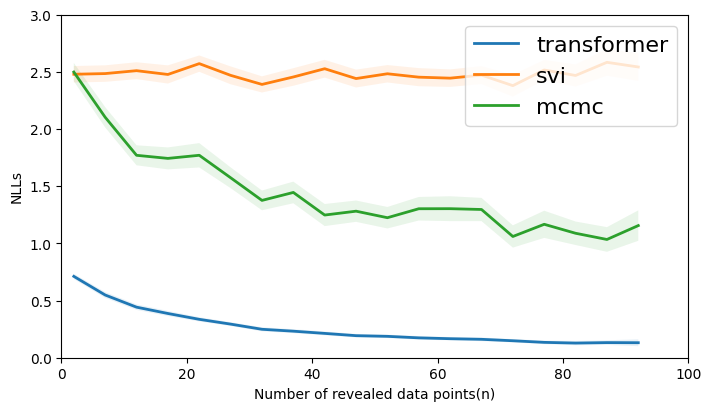

In [44]:
y_min = min([global_results[k][2].min() for k in global_results])
y_max = max([global_results[k][2].max() for k in global_results])

fig2 = plt.figure(constrained_layout=True, figsize=(7, 4))
axes = plt.axes()
axes.set_xlim(0, 100)
axes.set_ylim(0,3)
import scienceplots
with plt.style.context(['ieee','notebook']):
    for k in global_results:
        plot_with_confidence_intervals(plt, global_results[k][1], global_results[k][2], global_results[k][3], label=k)
        #plt.plot(global_results_train_steps[k][1], global_results_train_steps[k][0], label=k)
    plt.xlabel('Number of revealed data points(n)')
    plt.ylabel('NLLs')
    plt.legend(loc="upper right")
    plt.savefig('../test_curves/compare_other_algorithm/bayesian_svi_mcmc.png')
    plt.show()